Social network simulation  
Benjamin Rosche  
Feb 2020  

The purpose of this simulation is to create network data resembling Add Health's data on friendship networks.  
The created data mimicks the coevolution of network (ie. edges) and behavior of the nodes in these networks.  
The simulation consists of two functions  
<ul>
    <li>simSetup( nClusters=1, nNodes=30, directed=True )</li>
    <li>simCoevolution(G, iterations, homophily=[True,1,0], printG=False)</li>
</ul>
<b>simSetup</b> creates a networkx object and  
<b>simCoevolution</b> models the coevolution of network and behavior
<br /><br />
The output of simCoevolution are three Panda dataframes
<ul>
    <li><b>datNodes</b>: contains actor attributes</li>
    <li><b>datEdges</b>: contains edge attributes</li>
    <li><b>datNodesEdges</b>: contains node attributes, which are aggregated features of ego's neighbors (both node and edge features)</li>
</ul>
The data is then used to analyze how different methods perform in <b>separating selection from influence</b> under varying conditions of
<ul>
    <li>homophily</li>
    <li>tie probability / network density</li>
    <li>measurement error on network and behavior [not implemented yet]</li>
</ul>
The considered methods are
<ul>
    <li>simple linear regression</li>
    <li>Christakis and Fowler (2009) setup (lagged Y by two time points, and network fixed effects) [not implemented yet]</li>
    <li>stochastic actor-oriented model [not implemented yet]</li>
    <li>IV approach by Bramoullé et al. (2009) [not implemented yet]</li>
</ul>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import feather
import warnings
import random
from scipy import stats
from itertools import combinations 
from itertools import permutations
from sklearn import linear_model
lm = linear_model.LinearRegression()

In [22]:
def simSetup( nNodes=30, directed=True, seed=9001 ):
    
    """
    simSetup creates a networkx object 
    
    The function creates a networkx object with nodes exhibiting five node attributes, which initialized here
    S = exogenous dichotomous variable, which later will impact network formation ('selector') of ego and her friends (alter)
    I = exogenous normally distributed variable, which later will impact behavior ('influencor') of ego and her friends (alter)
    SI = exogenous normally distributed variable, which later will impact network formation and behavior of ego and her friends (alter)
    SES = exogenous ordinally distributed variable impacting network formation and behavior of ego and her friends (alter)
    achievement = endogenous normally distributed variable, which, initially, is a function of SES, but will later be further endogenized 
    
    Parameters:
    nClusters (int): To be programmed, clusters, such as schools
    nNodes (int): number of nodes in the network
    nNodes (boolean): True  network is directed, i.e. nNodes*(nNodes-1) possible edges
                      False network is undirected, i.e. nNodes*(nNodes-1)/2 possible edges
    
    Returns:
    networkx object: Networkx object G with with nNodes nodes and five node attributes
    """
    
    random.seed(seed)

    # Nodes 
    nodes = list(range(nNodes))

    # Edges
    if directed:
        G = nx.DiGraph()
        edges = list(permutations(nodes, 2))  # directed
    else:
        G = nx.Graph()
        edges = list(combinations(nodes, 2))  # undirected

    # Node attributes
    S = np.random.binomial(1, 0.5, nNodes)
    SI = np.random.normal(0,1, nNodes)
    SES = np.random.choice(list(range(0,5)), nNodes, p=[0.1,0.2,0.3,0.3,0.1])
    I = np.random.normal(0,1, nNodes)
    achievement = np.random.normal(1*SES, 1)

    # Add node attributes
    nodeAttrs = {
        i: {
            "S":S[i],
            "SI":SI[i],
            "SES":SES[i],
            "I":I[i],
            "achievement": achievement[i]
        }
        for i in nodes
    }

    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    nx.set_node_attributes(G, nodeAttrs)
    
    return G

In [43]:
def simCoevolution( G, iterations, homophily=[True,1,0], plotNet=False, seed=9001):
    
    """
    simCoevolution creates three Panda dataframes with simulated data that is the result of a coevolution of network and behavior on those networks
    
    The simulation takes the networkx object created in simSetup and starts a process of endogenous network formation and peer influence.
    The network formation process is guided by 
    - similarity in S
    - similarity in SI
    - similarity in SES
    - similarity in achievement
    I refer to those collectively as homophily.
    
    The peer influence is on achievement. Achievement is a function of
    - ego's previous achievement, SI, SES, and I
    - friends' average concurrent achievement, average SI, average I, 
    - average SES difference of friends with higher SES then ego ('cross-class friendships')
    - whether ego is a longer (has zero friends)

    Parameters:
    G (networkx object): networkx object created in simSetup 
    iterations (int): number of waves
    homophily (vector): 1. (boolean): switches homophily on/off
                        2. (float): if homophily is on, it sets homophily strength (ie impact of similarity in S, similarity in SI, ...)
                                    if homophily is off, does nothing
                        3. (float): if homophily is on, average tie probability as intercept of sigmoid function
                                    if homophily is off, average tie probability between 0 and 1
    plotNet (boolean): Plot network 
    
    Returns:
    datNodes (Panda dataframe): node attributes
    datEdges (Panda dataframe): edge attributes
    datNodesEdges (Panda dataframe): node attributes that are based on friends and edges attributes 
    """
    
    random.seed(seed)

    # Number of nodes and edges
    nNodes = G.number_of_nodes()
    nEdges = G.number_of_edges()

    # Determine whether directed network
    if(nEdges==nNodes*(nNodes-1)):
        directed = True
    else:
        directed = False

    # Exogenous edge attributes: S, SI, SES, cross-class
    sim_S, sim_SI, sim_SES, crossclass = [], [], [], []

    for ego, alter in list(G.edges()):
        sim_S = np.append(sim_S, G.nodes[ego]['S'] == G.nodes[alter]['S'])
        sim_SI = np.append(sim_SI, abs(G.nodes[ego]['SI'] - G.nodes[alter]['SI']))
        sim_SES = np.append(sim_SES, abs(G.nodes[ego]['SES'] - G.nodes[alter]['SES']))
        crossclass = np.append(crossclass, (G.nodes[alter]['SES'] - G.nodes[ego]['SES'])) # np.append(crossclass, (G.nodes[ego]['SES'] < G.nodes[alter]['SES']) * (G.nodes[alter]['SES'] - G.nodes[ego]['SES']))  

    sim_SI, sim_SES = stats.zscore(max(sim_SI) - sim_SI), stats.zscore(max(sim_SES) - sim_SES)

    # Add edge attributes
    edgeExoAttrs = {
        (i,j): {
            "sim_S":sim_S[k],
            "sim_SI":sim_SI[k],
            "sim_SES":sim_SES[k],
            "crossclass":crossclass[k],
        }
        for k, (i, j) in enumerate(G.edges())
    }

    nx.set_edge_attributes(G, edgeExoAttrs)

    # Functions to aggregate node and edge attributes of friends of ego
    def nodeAggr(feature):
        """
        This helper function aggregates (at the moment: by taking the average) feature values of all neighbors (ie friends) of a node
        
        Parameters:
        feature (string): node feature, such as S, SI, SES, I, or achievement
        
        Returns:
        neighborAttrs (list): mean value of feature of all neighbors of each node; i.e. len(neighborAttrs) == nNodes
        """
        neighborAttrs = [np.nanmean([H.nodes[x][feature] for x in H.neighbors(i)]) for i in list(H.nodes)] # aggregate features values of all neighbors
        neighborAttrs = [x if not np.isnan(neighborAttrs)[i] else 0 for i, x in enumerate(neighborAttrs)]  # if no neighbors, return 0 instead of nan 
        return neighborAttrs

    def edgeAggr(feature=None):
        """
        This helper function aggregates (at the moment: by taking the average) values of edge features of all edges ego is involved in
        
        Parameters:
        feature (string): edge feature, such as sim_S, sim_SI, sim_SES, sim_achievement, crossclass
        If feature=None, the number of edges is returned
         
        Returns:
        edgeAttrs (list): mean value of edge features of all edges ego is involved in; i.e. len(edgeAttrs) == nNodes
                          if feature=None, the number of edges for each node is returned
        """
        if feature:
            edgeAttrs = [np.nanmean([H.edges[x][feature] for x in H.edges(i)]) for i in list(H.nodes)] # aggregate features values of all edges involving ego
            edgeAttrs = [x if not np.isnan(edgeAttrs)[i] else 0 for i, x in enumerate(edgeAttrs)]      # if no edges, return 0 instead of nan 
        else:
            # if no feature defined, give number of neighbors
            edgeAttrs = [len(H[i]) for i in list(H.nodes)]
        return edgeAttrs

    # Iterate through waves ========================================================================= # 

    wave = 1

    # Container
    datNodes = pd.DataFrame()
    datNodesEdges = pd.DataFrame()
    datEdges = pd.DataFrame()

    while wave <= iterations:

        # Endogenous edge attributes: achievement
        sim_achievement = []
        for ego, alter in list(G.edges()):
            sim_achievement = np.append(sim_achievement, abs(G.nodes[ego]['achievement'] - G.nodes[alter]['achievement']))
        sim_achievement = stats.zscore(max(sim_achievement) - sim_achievement)

        edgeEndoAttrs = {
            (i,j): {
                "sim_achievement": sim_achievement[k]
            }
            for k, (i, j)  in enumerate(G.edges())
        }

        nx.set_edge_attributes(G, edgeEndoAttrs)

        # Selection ================================================================================== # 

        if(homophily[0]==True):
            edgePropensities = 1 / (1 + np.exp(-(homophily[2]+homophily[1]*sim_S + homophily[1]*sim_SI + homophily[1]*sim_SES + homophily[1]*sim_achievement)))
        else:
            edgePropensities = np.repeat(homophily[2], nEdges)

        edgeRealizations = [(i,j) for k,(i,j) in enumerate(G.edges())  if not np.random.binomial(1, edgePropensities[k])]

        # Subgraph with all nodes but only realized edges
        H = G.copy()
        H.remove_edges_from(edgeRealizations)
        
        # Plot subgraphs
        if plotNet:
            pos = nx.spring_layout(H)
            nx.draw(H, pos, with_labels=True, font_weight='bold')
            node_labels = {key:("SES="+str(value)) for (key,value) in nx.get_node_attributes(H,'SES').items()}
            edge_labels = {key:("CSF="+str(value)) for (key,value) in nx.get_edge_attributes(H,'crossclass').items()}
            nx.draw_networkx_labels(H, {key:(value1-0.1) for (key,value1) in pos.items()}, labels = node_labels, font_color="red")
            nx.draw_networkx_edge_labels(H, pos, edge_labels = edge_labels, font_color="red")
            plt.savefig("p%s.png" % (wave), dpi=300)
            plt.show()

        # Influence ================================================================================= #

        datNodes = datNodes.append(pd.DataFrame({
            "ego": list(H.nodes()),
            "wave": wave,
            "S": [H.nodes[x]['S'] for x in H.nodes],
            "SI": [H.nodes[x]['SI'] for x in H.nodes],
            "I": [H.nodes[x]['I'] for x in H.nodes],
            "SES": [H.nodes[x]['SES'] for x in H.nodes],
            "achievement": [H.nodes[x]['achievement'] for x in H.nodes],
            "mobility": 0
        }), ignore_index=True)

        datEdges = datEdges.append(pd.DataFrame({
            "ego": np.array(H.edges())[:,0],
            "alter": np.array(H.edges())[:,1],
            "wave": wave,
            "sim_S": [H.edges[x]['sim_S'] for x in H.edges],
            "sim_SI": [H.edges[x]['sim_SI'] for x in H.edges],
            "sim_SES": [H.edges[x]['sim_SES'] for x in H.edges],
            "sim_achievement": [H.edges[x]['sim_achievement'] for x in H.edges],
            "crossclass": [H.edges[x]['crossclass'] for x in H.edges]
        }), ignore_index=True)

        datNodesEdges = datNodesEdges.append(pd.DataFrame({
            "ego": list(H.nodes()),
            "wave": wave,
            "alter_SI": np.array(nodeAggr("SI")),
            "alter_SES": np.array(nodeAggr("SES")),
            "alter_I": np.array(nodeAggr("I")),
            "alter_achievement": np.array(nodeAggr("achievement")),
            "sim_S": np.array(edgeAggr("sim_S")), 
            "sim_SI": np.array(edgeAggr("sim_SI")), 
            "sim_SES": np.array(edgeAggr("sim_SES")), 
            "sim_achievement": np.array(edgeAggr("sim_achievement")), 
            "crossclass": np.array(edgeAggr("crossclass")), 
            "loner": np.array(edgeAggr())
        }), ignore_index=True)

        # endogenize achievement
        achievement = 1 * np.array([H.nodes[x]['achievement'] for x in H.nodes]) + \
                      1 * np.array([H.nodes[x]['SI'] for x in H.nodes]) + \
                      1 * np.array([H.nodes[x]['SES'] for x in H.nodes]) + \
                      1 * np.array([H.nodes[x]['I'] for x in H.nodes]) + \
                      1 * np.array(nodeAggr("achievement")) + \
                      1 * np.array(nodeAggr("SI")) + \
                      1 * np.array(nodeAggr("I")) + \
                     -1 * np.array(edgeAggr()==np.zeros(nNodes)) + \
                      1 * np.array(edgeAggr("crossclass")) 

        # Add new achievement to complete graph
        nodeAttrs = {
            i: {
                "achievement": achievement[i]
            }
            for i in list(G.nodes)
        }
        nx.set_node_attributes(G, nodeAttrs)

        wave = wave+1
    
    # Intergenerational mobility, which is based on endogenous achievement, SES, and cross-class friendship
    probMobility = 1 * np.array([G.nodes[x]['achievement'] for x in G.nodes]) + \
                   1 * np.array([G.nodes[x]['SES'] for x in G.nodes]) + \
                   1 * np.array(edgeAggr("crossclass")) # only last wave (probably not reasonable)
    probMobility = probMobility - np.mean(probMobility)

    mobility = np.random.binomial(1, 1 / (1 + np.exp(-(probMobility))), nNodes) * [G.nodes[x]['SES']<4 for x in G.nodes] # mobility based on propensity if not already at the top

    datNodes['mobility'] = np.tile(mobility, iterations)
    
    return datNodes, datNodesEdges, datEdges

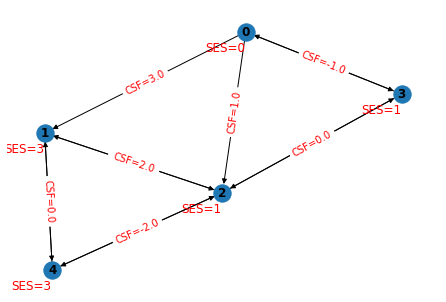

,ego,wave,S,SI,I,SES,achievement,mobility
0,0,1,0,0.876991,-0.855062,0,-0.458778,0
1,1,1,0,-0.508484,0.479916,3,3.503526,1
2,2,1,1,0.847401,-0.514787,1,2.543054,1
3,3,1,0,0.099244,0.493797,1,1.597270,0
4,4,1,1,-1.661558,-0.033970,3,3.384796,0


In [45]:
G = simSetup(nNodes=5, directed=True)
datNodes, datNodesEdges, datEdges = simCoevolution(G, iterations=1, homophily=[True,1,0], plotNet=True)
datNodes.head()

## Analysis
I analyze the impact of homophily and overall tie probability on the bias of the estimator of a pooled regression model.

0 0.0
1 0.1
2 0.2
3 0.3
4 0.4
5 0.5
6 0.6
7 0.7
8 0.8
9 0.9
10 1.0
11 1.1
12 1.2
13 1.3
14 1.4
15 1.5
16 1.6
17 1.7
18 1.8
19 1.9


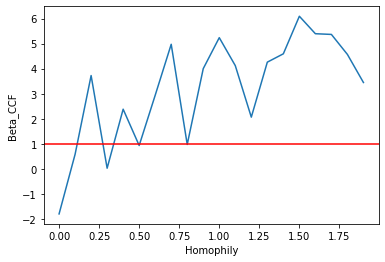

In [35]:
# Impact of homophily
# The plot shows that the bias is positive and increases with increasing strength of homophily

homoseq = np.arange(0,2,0.1)

resultSim = pd.DataFrame({'homoseq': homoseq,
                          'CCF': np.nan})
for i, homo in enumerate(homoseq):
    
    print(i,round(homo,1))
    
    G = simSetup(nNodes=50)
    datNodes, datNodesEdges, datEdges = simCoevolution(G, iterations=3, homophily=[True,homo,0], plotNet=False)
    
    X = pd.concat([datNodes.SES, datNodes.achievement.shift(), datNodesEdges.alter_achievement, datNodesEdges.crossclass], axis=1).dropna()
    y = datNodes.achievement[1:]
    
    model = lm.fit(X,y)
    resultSim.iat[i, 1] = lm.coef_[3]


plt.plot(homoseq, resultSim.CCF)
plt.axhline(y=1, color='r')
plt.xlabel('Homophily')
plt.ylabel('Beta_CCF')
plt.show()

0 1.0
1 0.9
2 0.8
3 0.7
4 0.6
5 0.5
6 0.4
7 0.3
8 0.2
9 0.1


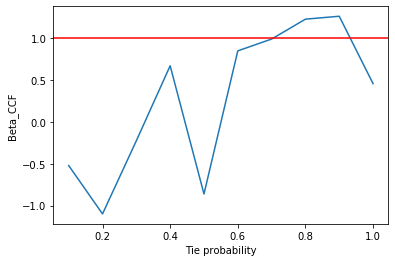

In [36]:
# Impact of friendship network size / tie probability
# The plot shows that small networks have less power to detect influence effects

probseq = 1-np.arange(0,1,0.1)

resultSim = pd.DataFrame({'probseq': probseq,
                          'CCF': np.nan})
for i, prob in enumerate(probseq):
    
    print(i,round(prob,1))
    
    G = simSetup(nNodes=50)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        datNodes, datNodesEdges, datEdges = simCoevolution(G, iterations=3, homophily=[False,0,prob], plotNet=False)
    
    X = pd.concat([datNodes.SES, datNodes.achievement.shift(), datNodesEdges.alter_achievement, datNodesEdges.crossclass], axis=1).dropna()
    y = datNodes.achievement[1:]
    
    model = lm.fit(X,y)
    resultSim.iat[i, 1] = lm.coef_[3]


plt.plot(probseq, resultSim.CCF)
plt.axhline(y=1, color='r')
plt.xlabel('Tie probability')
plt.ylabel('Beta_CCF')
plt.show()

In [7]:
# Save to R
feather.write_dataframe(datNodes, 'datNodes.feather')
feather.write_dataframe(datNodesEdges, 'datNodesEdges.feather')
feather.write_dataframe(datEdges, 'datEdges.feather')